# Import Libraries

In [104]:
# Basic libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Feature engineering
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [105]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Import Data

In [106]:
# Import data
train = pd.read_csv('/gdrive/MyDrive/Datasets/Carvana/training.csv')
test = pd.read_csv('/gdrive/MyDrive/Datasets/Carvana/test.csv')
submission = test[['RefId']]

In [107]:
submission_log = submission

In [108]:
pd.set_option('display.max_columns', None)
train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


# EDA

In [109]:
with open('/gdrive/MyDrive/Datasets/Carvana/Carvana_Data_Dictionary.txt') as file:
  print(file.read())

Field Name				Definition
RefID				        Unique (sequential) number assigned to vehicles
IsBadBuy				Identifies if the kicked vehicle was an avoidable purchase 
PurchDate				The Date the vehicle was Purchased at Auction
Auction					Auction provider at which the  vehicle was purchased
VehYear					The manufacturer's year of the vehicle
VehicleAge				The Years elapsed since the manufacturer's year
Make					Vehicle Manufacturer 
Model					Vehicle Model
Trim					Vehicle Trim Level
SubModel				Vehicle Submodel
Color					Vehicle Color
Transmission				Vehicles transmission type (Automatic, Manual)
WheelTypeID				The type id of the vehicle wheel
WheelType				The vehicle wheel type description (Alloy, Covers)
VehOdo					The vehicles odometer reading
Nationality				The Manufacturer's country
Size					The size category of the vehicle (Compact, SUV, etc.)
TopThreeAmericanName			Identifies if the manufacturer is one of the top three American manufacturers
MMRAcquisitionAuctionAveragePrice	Acquisiti

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [110]:
numerical_features = train.select_dtypes(include = ['float64', 'int64']).columns.drop('RefId')
categorical_features = train.select_dtypes(include = ['object']).columns

In [111]:
# Can create a heatmap to discover which numerical features have high collinearity - then remove those variables
numerical_features

Index(['IsBadBuy', 'VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO',
       'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0d4b367f0>,
      dtype=object)

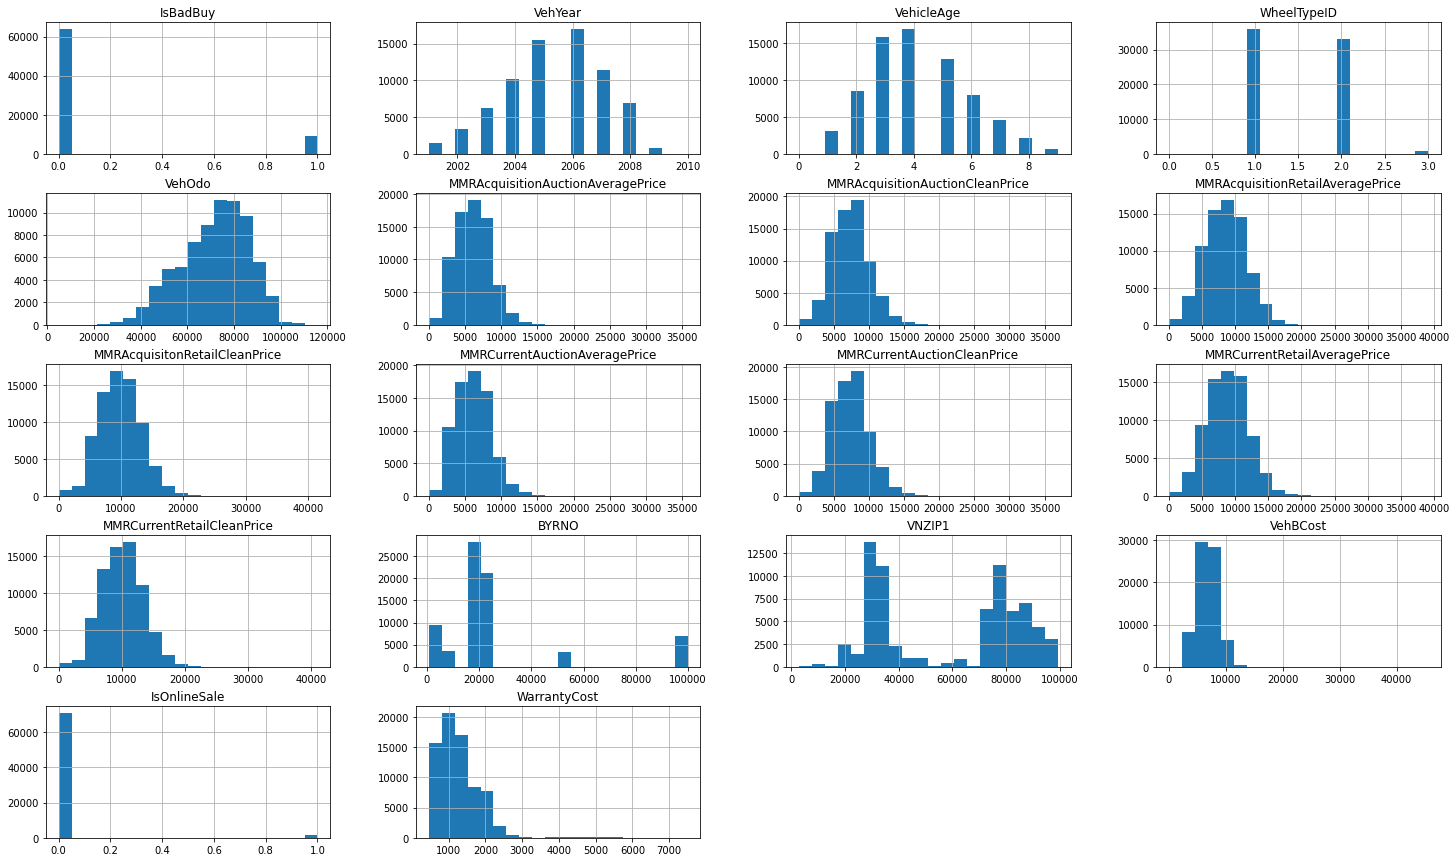

In [49]:
train[numerical_features].hist(figsize=(25,15), bins=20)

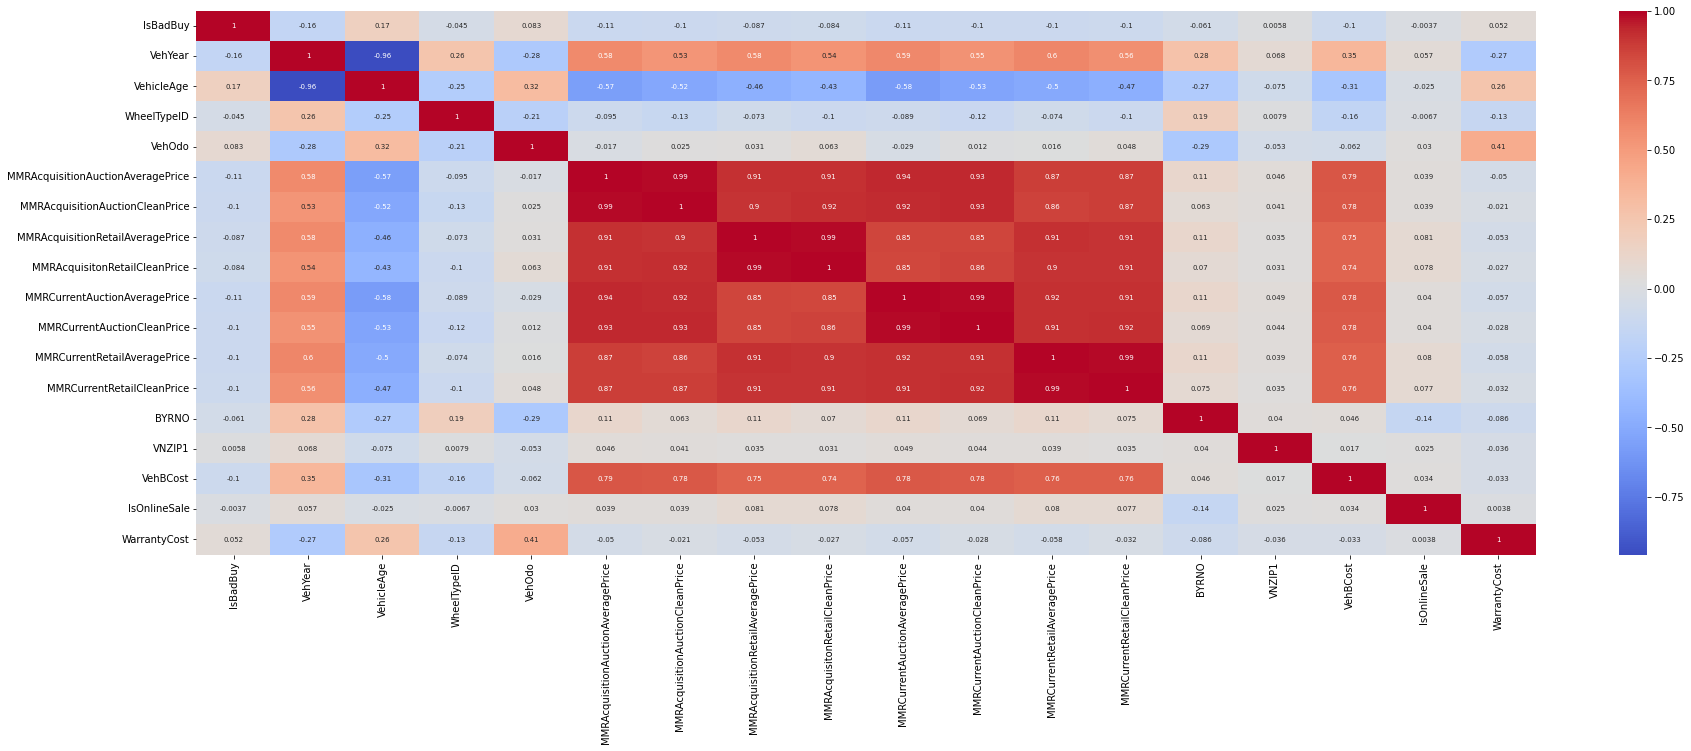

In [78]:
plt.figure(figsize=(30,10))
sns.heatmap(train[numerical_features].corr(), annot=True, annot_kws={"size":7}, cmap='coolwarm')

High multicollinearity within MMRAcquisitionAuctionAveragePrice and the following:

'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost'

Should remove these variables^


In [79]:
categorical_features

Index(['PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color',
       'Transmission', 'WheelType', 'Nationality', 'Size',
       'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST'],
      dtype='object')

In [80]:
train[categorical_features].describe()

,PurchDate,Auction,Make,Model,Trim,SubModel,Color,Transmission,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,VNST
count,72983,72983,72983,72983,70623,72975,72975,72974,69809,72978,72978,72978,3419,3419,72983
unique,517,3,33,1063,134,863,16,3,3,4,12,4,2,2,37
top,11/23/2010,MANHEIM,CHEVROLET,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,Alloy,AMERICAN,MEDIUM,GM,NO,GREEN,TX
freq,384,41043,17248,2329,13950,15236,14875,70398,36050,61028,30785,25314,3357,3340,13596


Variables with lots of unique values (I like to cap at 20 for dummy variables):
'PurchDate', 'Make', 'Model', 'Trim', 'SubModel', 'VNST'
But, could transform Purchdate into sin/cos for cyclality

# Variable Selection

In [112]:
redundant = ['RefId', 'BYRNO']
lots_of_cats = ['Make', 'Model', 'Trim', 'SubModel', 'VNST']
high_corr = ['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost']

In [113]:
# train
train['Month_sin'] = np.sin(2*np.pi*pd.DatetimeIndex(train['PurchDate']).month/12)
train['Month_cos'] = np.cos(2*np.pi*pd.DatetimeIndex(train['PurchDate']).month/12)
train['Day_sin'] = np.sin(2*np.pi*pd.DatetimeIndex(train['PurchDate']).day/31)
train['Day_cos'] = np.cos(2*np.pi*pd.DatetimeIndex(train['PurchDate']).day/31)
# test
test['Month_sin'] = np.sin(2*np.pi*pd.DatetimeIndex(test['PurchDate']).month/12)
test['Month_cos'] = np.cos(2*np.pi*pd.DatetimeIndex(test['PurchDate']).month/12)
test['Day_sin'] = np.sin(2*np.pi*pd.DatetimeIndex(test['PurchDate']).day/31)
test['Day_cos'] = np.cos(2*np.pi*pd.DatetimeIndex(test['PurchDate']).day/31)

In [114]:
col_drop = redundant + lots_of_cats + high_corr + ['PurchDate']
print(col_drop)

['RefId', 'BYRNO', 'Make', 'Model', 'Trim', 'SubModel', 'VNST', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost', 'PurchDate']


In [115]:
train.drop(col_drop, inplace=True, axis=1)
test.drop(col_drop, inplace=True, axis=1)

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IsBadBuy                           72983 non-null  int64  
 1   Auction                            72983 non-null  object 
 2   VehYear                            72983 non-null  int64  
 3   VehicleAge                         72983 non-null  int64  
 4   Color                              72975 non-null  object 
 5   Transmission                       72974 non-null  object 
 6   WheelTypeID                        69814 non-null  float64
 7   WheelType                          69809 non-null  object 
 8   VehOdo                             72983 non-null  int64  
 9   Nationality                        72978 non-null  object 
 10  Size                               72978 non-null  object 
 11  TopThreeAmericanName               72978 non-null  obj

In [90]:
targets=train['IsBadBuy']
train.drop('IsBadBuy', inplace=True, axis=1)

# Missing Values

In [86]:
print("Train\n", train.isnull().sum(), "\n---------------\n")
print("Test\n", test.isnull().sum())

Train
 IsBadBuy                                 0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
PRIMEUNIT                            69564
AUCGUART                             69564
VNZIP1                                   0
IsOnlineSale                             0
WarrantyCost                             0
Month_sin                                0
Month_cos                                0
Day_sin                                  0
Day_cos                                  0
dtype: int64 
---------------

Test
 Auction   

In [91]:
numerical_features = train.select_dtypes(include = ['float64', 'int64']).columns
categorical_features = train.select_dtypes(include = ['object']).columns

In [92]:
from sklearn import impute
# Replace numerical missing values with median value bc robust to outliers
imputer = SimpleImputer(strategy='median')
imputer.fit(train[numerical_features])
train[numerical_features] = imputer.transform(train[numerical_features])
test[numerical_features] = imputer.transform(test[numerical_features])

In [93]:
# Add Unknown for missing values in categorical variables
for i in categorical_features:
  train[i].fillna('Unknown', inplace=True)
  test[i].fillna('Unknown', inplace=True)

In [94]:
# double check missing values
print("Train\n", train.isnull().sum(), "\n---------------\n")
print("Test\n", test.isnull().sum())

Train
 Auction                              0
VehYear                              0
VehicleAge                           0
Color                                0
Transmission                         0
WheelTypeID                          0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
PRIMEUNIT                            0
AUCGUART                             0
VNZIP1                               0
IsOnlineSale                         0
WarrantyCost                         0
Month_sin                            0
Month_cos                            0
Day_sin                              0
Day_cos                              0
dtype: int64 
---------------

Test
 Auction                              0
VehYear                              0
VehicleAge                           0
Color               

# Normalize Numerical Data and Encode Categorical Data

In [95]:
# Normalization of Numerical Data
scaler = MinMaxScaler()
scaler.fit(train[numerical_features])
train[numerical_features] = scaler.transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

In [96]:
# One-Hot Encoding of Categorical Data
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train[categorical_features])
encode_cols = list(encoder.get_feature_names(categorical_features))
train[encode_cols] = encoder.transform(train[categorical_features])
test[encode_cols] = encoder.transform(test[categorical_features])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [97]:
all_var = list(numerical_features) + encode_cols
train = train[all_var]
test = test[all_var]

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48707 entries, 0 to 48706
Data columns (total 69 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   VehYear                            48707 non-null  float64
 1   VehicleAge                         48707 non-null  float64
 2   WheelTypeID                        48707 non-null  float64
 3   VehOdo                             48707 non-null  float64
 4   MMRAcquisitionAuctionAveragePrice  48707 non-null  float64
 5   VNZIP1                             48707 non-null  float64
 6   IsOnlineSale                       48707 non-null  float64
 7   WarrantyCost                       48707 non-null  float64
 8   Month_sin                          48707 non-null  float64
 9   Month_cos                          48707 non-null  float64
 10  Day_sin                            48707 non-null  float64
 11  Day_cos                            48707 non-null  flo

# Modeling

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.15, random_state=0)

In [30]:
# Logistic Regression
logreg = LogisticRegression()
clf = logreg.fit(X_train, y_train)
acc_train_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_test_log = round(logreg.score(X_test, y_test) * 100, 2)
roc_test_log = round(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]),3)
print('logistic regression train accurary: ', acc_train_log)
print('logistic regression test accurary: ', acc_test_log)
print('logistic regression test ROC: ', roc_test_log)

logistic regression train accurary:  89.5
logistic regression test accurary:  89.56
logistic regression test ROC:  0.754


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
clf = random_forest.fit(X_train, y_train)
acc_train_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_test_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
roc_test_random_forest = round(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]),3)
print('Random Forest train accurary: ', acc_train_random_forest)
print('Random Forest test accurary: ', acc_test_random_forest)
print('Random Fores test ROC: ', roc_test_random_forest)

Random Forest train accurary:  100.0
Random Forest test accurary:  90.11
Random Fores test ROC:  0.757


In [33]:
# XGBoost
xgb = XGBClassifier()
clr = xgb.fit(X_train, y_train)
acc_train_xgb = round(xgb.score(X_train, y_train) * 100, 2)
acc_test_xgb = round(logreg.score(X_test, y_test) * 100, 2)
roc_test_xgb = round(roc_auc_score(y_test, clr.predict_proba(X_test)[:, 1]),3)
print('xgb train accurary: ', acc_train_xgb)
print('xgb test accurary: ', acc_test_xgb)
print('xgb test ROC: ', roc_test_xgb)

xgb train accurary:  90.03
xgb test accurary:  89.56
xgb test ROC:  0.767


In [34]:
# LightGBM
lgbm = LGBMClassifier()
clr = lgbm.fit(X_train, y_train)
acc_train_lgbm = round(lgbm.score(X_train, y_train) * 100, 2)
acc_test_lgbm = round(lgbm.score(X_test, y_test) * 100, 2)
roc_test_lgbm = round(roc_auc_score(y_test, clr.predict_proba(X_test)[:, 1]),3)
print('lgbm train accurary: ', acc_train_lgbm)
print('lgbm test accurary: ', acc_test_lgbm)
print('lgbm test ROC: ', roc_test_lgbm)

lgbm train accurary:  90.44
lgbm test accurary:  90.4
lgbm test ROC:  0.769


# Predict with Best Model - LGBM

In [139]:
clr = lgbm.fit(train, targets)
predictions = clr.predict_proba(test)[:, 1]
submission['IsBadBuy'] = predictions
submission.to_csv('Submissions_lgbm.csv',index=False)

In [140]:
submission.head()

,RefId,IsBadBuy
0,73015,0.097400
1,73016,0.064354
2,73017,0.050593
3,73018,0.289123
4,73019,0.829162


In [141]:
from google.colab import files
files.download('Submissions_lgbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Try Output with Logistic Regression

In [143]:
clr_log = logreg.fit(train, targets)
predictions_log = clr_log.predict_proba(test)[:, 1]
submission_log['IsBadBuy'] = predictions_log
submission_log.to_csv('Submissions_logreg.csv', index=False)
files.download('Submissions_logreg.csv')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Export Data

In [100]:
from google.colab import files
train.to_csv('carvana_train_clean.csv', index=False)
files.download('carvana_train_clean.csv')
test.to_csv('carvana_test_clean.csv', index=False)
files.download('carvana_test_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
submission.to_csv('carvana_submit_clean.csv', index=False)
files.download('carvana_submit_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
targets.to_csv('targets_carvana.csv', index=False)
files.download('targets_carvana.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>